# 로이터 뉴스 분류하기 -LSTM

데이터 탐색


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

In [2]:
(X_train, y_train),(X_test,y_test) = reuters.load_data()
len(X_train),len(X_test)

2121728/2110848 [==============================] - 0s 0us/step


(8982, 2246)

In [3]:
#카테고리 개수
max(y_train) + 1

46

In [4]:
#첫번째 뉴스
print(X_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [5]:
type(reuters.get_word_index())

565248/550378 [==============================] - 0s 0us/step


dict

In [6]:
reuters.get_word_index()['the']
#가장 빈도 높은 단어 = the

1

In [7]:
index_word = {}
for key, value in reuters.get_word_index().items():
    index_word[value] = key
len(index_word)

30979

In [8]:
#첫번째 기사 복원
' '.join(index_word[index] for index in X_train[0])

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

In [9]:
#뉴스 기사의 길이 - 최대, 평균
max(len(s) for s in X_train), sum(map(len,X_train)) / len(X_train)

(2376, 145.5398574927633)

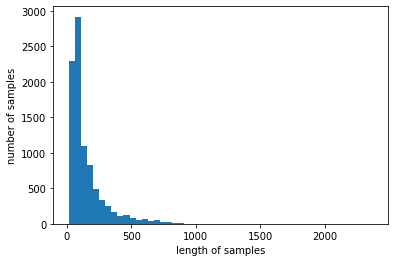

In [10]:
# 뉴스 기사 단어 수의 분포
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


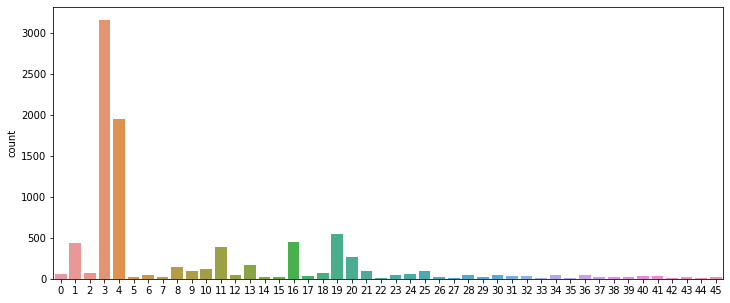

In [11]:
#뉴스 그룹의 분포
plt.figure(figsize=(12,5))
sns.countplot(y_train);

- 최대 길이는 2376이지만 단어 수 분포 보면 500개 아래에 모여있다. 이대로라면 1800개의 패딩을 겁나 넣어야 한다. 또 사실 중요한 말은 다 앞에 있다. 
그래서 일정 단어 수 이하로 자르는 게 나을 수 있다. 

- 단어 수는 30979개지만 이걸 다 쓰진 않을 것. 잘 쓰지 않는 단어까지 포함하는 것도 별로다.

### LSTM으로 로이터 뉴스 분류
- 문장 길이:100단어까지(최대-2376)
- 단어:빈도 수 기준 1000개 까지만.

In [12]:
max_words=1000
max_len=100

In [13]:
(X_train, y_train),(X_test,y_test) = reuters.load_data(
    num_words=max_words,
    test_split=0.2
)
len(X_train),len(X_test)

(8982, 2246)

In [14]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [15]:
X_train=pad_sequences(X_train,maxlen=max_len)
X_test=pad_sequences(X_test,maxlen=max_len)
Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((8982, 100), (2246, 100), (8982, 46), (2246, 46))

- 모델 정의/실행/학습

In [16]:
model=Sequential([
                  Embedding(max_words,64,input_length=max_len),
                  LSTM(100),
                  Dense(46,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           64000     
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 46)                4646      
                                                                 
Total params: 134,646
Trainable params: 134,646
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile('adam','categorical_crossentropy',['accuracy'])

In [18]:
model_path='best-reuters-lstm.h5'
mc=ModelCheckpoint(model_path,verbose=1,save_best_only=True)
es=EarlyStopping(patience=10)

In [19]:
hist=model.fit(
    X_train,Y_train,validation_split=0.2,
    epochs=100,batch_size=128,callbacks=[mc,es]
)

Epoch 1/100
51/57 [=========================>....] - ETA: 0s - loss: 2.7739 - accuracy: 0.3465
Epoch 1: val_loss improved from inf to 2.40544, saving model to best-reuters-lstm.h5
57/57 [==============================] - 8s 20ms/step - loss: 2.7387 - accuracy: 0.3468 - val_loss: 2.4054 - val_accuracy: 0.3450
Epoch 2/100
51/57 [=========================>....] - ETA: 0s - loss: 2.4070 - accuracy: 0.3487
Epoch 2: val_loss improved from 2.40544 to 2.20334, saving model to best-reuters-lstm.h5
57/57 [==============================] - 1s 10ms/step - loss: 2.3880 - accuracy: 0.3537 - val_loss: 2.2033 - val_accuracy: 0.4040
Epoch 3/100
52/57 [==========================>...] - ETA: 0s - loss: 2.0902 - accuracy: 0.4698
Epoch 3: val_loss improved from 2.20334 to 1.94462, saving model to best-reuters-lstm.h5
57/57 [==============================] - 1s 10ms/step - loss: 2.0851 - accuracy: 0.4711 - val_loss: 1.9446 - val_accuracy: 0.4880
Epoch 4/100
55/57 [===========================>..] - ETA: 0s -

In [22]:
best_model=load_model(model_path)
best_model.evaluate(X_test,Y_test)

71/71 [==============================] - 1s 6ms/step - loss: 1.3088 - accuracy: 0.6870


[1.3088468313217163, 0.6869990825653076]

학습과정 시각화

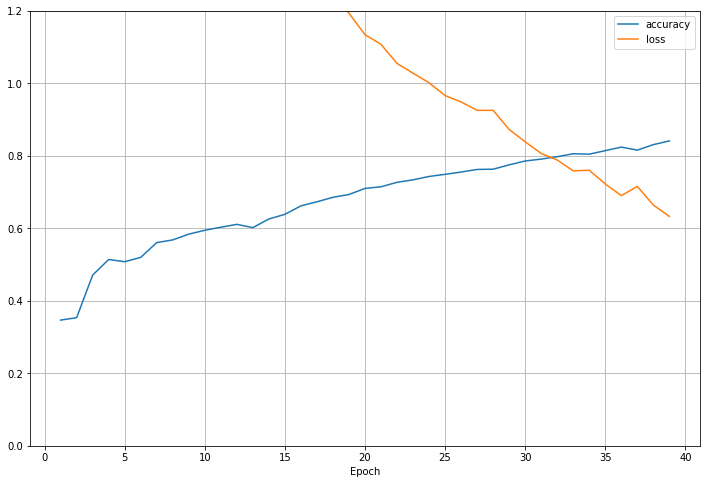

In [23]:
y_acc=hist.history['accuracy']
y_loss=hist.history['loss']
xs=np.arange(1,len(y_acc)+1)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(xs,y_acc,label='accuracy')
plt.plot(xs,y_loss,label='loss')
plt.legend(),plt.grid()
plt.ylim(0,1.2),plt.xlabel('Epoch')
plt.show()